In [1]:
import sys
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:37:41) 
[Clang 10.0.1 ]


# Model Evaluation 
Name: Andrew Auyeung  
Location: 'lib/model_eval.ipynb'  

Target metrics for prediction of rain is centered around recall 

Version 1: Models trained on Base Weather Station Data  
Version 2: Models trained on Base Weather Station Data with Hurricane/Storm Data.    
Models will add class weight parameters added into the gridsearch for logisticregression and randomforest.   
Version 3: Ensemble Stacking of Models

In [2]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

In [3]:
# Open models from Version *v* 
v = 5
knn = pickle.load(open(f'../models/Version {v}/knn.pickle', 'rb'))
logreg = pickle.load(open(f'../models/Version {v}/logreg.pickle', 'rb'))
rf = pickle.load(open(f'../models/Version {v}/rf.pickle', 'rb'))
xgb = pickle.load(open(f'../models/Version {v}/xgb.pickle', 'rb'))
vote = pickle.load(open(f'../models/Version {v}/vote.pickle', 'rb'))
# baseline = pickle.load(open(f'../models/Version {v}/baseline.pickle', 'rb'))
test_holdout = pickle.load(open(f'../models/Version {v}/data.pickle', 'rb'))

In [4]:
X_test = test_holdout['X_test']
y_test = test_holdout['y_test']
X_holdout = test_holdout['X_holdout']
y_holdout = test_holdout['y_holdout']

In [5]:
# Predict Proba from X_test 
knn_proba = knn.predict_proba(X_test)
logreg_proba = logreg.predict_proba(X_test)
rf_proba = rf.predict_proba(X_test)
xgb_proba = xgb.predict_proba(X_test)
vote_proba = vote.predict_proba(X_test)

# Base Predictions
knn_preds = knn.predict(X_test)
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)
vote_preds = vote.predict(X_test)

preds = ['knn_preds', 'logreg_preds', 'rf_preds', 'xgb_preds', 'vote_preds']


In [6]:
rf.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__min_samples_split': 2,
 'rf__n_estimators': 350}

In [7]:
# Classification Reports
for model in preds: 
    print(model[:-6]+' Confusion Matrix')
    print(confusion_matrix(y_test, eval(model)))
    print('\n'+model[:-6]+' Classification Report')
    print(classification_report(y_test, eval(model)))
    

knn Confusion Matrix
[[1621  612]
 [ 638  495]]

knn Classification Report
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      2233
           1       0.45      0.44      0.44      1133

    accuracy                           0.63      3366
   macro avg       0.58      0.58      0.58      3366
weighted avg       0.63      0.63      0.63      3366

logreg Confusion Matrix
[[1376  857]
 [ 433  700]]

logreg Classification Report
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      2233
           1       0.45      0.62      0.52      1133

    accuracy                           0.62      3366
   macro avg       0.61      0.62      0.60      3366
weighted avg       0.66      0.62      0.63      3366

rf Confusion Matrix
[[1608  625]
 [ 530  603]]

rf Classification Report
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      2233
        

From the Classification Reports, the KNearestNeighbors Classifier has the best recall.  On days that it does rain, the model correctly predicts rain 68% of the time.  XGBoost had the highest precision where 67% of the days it predicted rain, it was correct.  

On predicting days of no rain, Random Forest and XGBoost both perform better.  

In [8]:
knn_proba = knn_proba[:,1]
logreg_proba = logreg_proba[:,1]
rf_proba = rf_proba[:,1]
xgb_proba = xgb_proba[:,1]

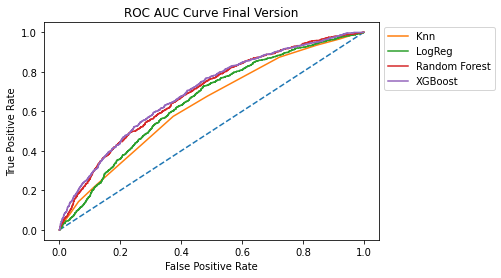

In [9]:
# ROC AUC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba, pos_label=1)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_proba, pos_label=1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba, pos_label=1)
x_ = np.linspace(0, 1, 1000)
y_ = x_
plt.plot(x_, y_, '--')
plt.plot(fpr_knn, tpr_knn, label='Knn')
plt.plot(fpr_logreg, tpr_logreg, label='LogReg')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1,1))
plt.title('ROC AUC Curve Final Version');

XGBoost outperforms the other models in terms of ROC. 
Potential threshold is 0.4. 

<AxesSubplot:xlabel='param_knn__n_neighbors', ylabel='mean_test_score'>

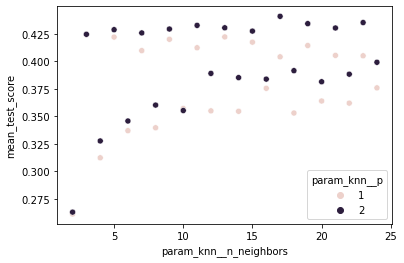

In [10]:
knn_df = pd.DataFrame(knn.cv_results_)
sns.scatterplot(x='param_knn__n_neighbors', y='mean_test_score', data=knn_df, hue='param_knn__p')

<AxesSubplot:xlabel='param_rf__n_estimators', ylabel='mean_test_score'>

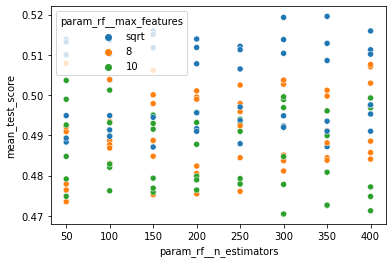

In [11]:
rf_df = pd.DataFrame(rf.cv_results_)
sns.scatterplot(x='param_rf__n_estimators', y='mean_test_score', data=rf_df, hue='param_rf__max_features')

In [12]:
knn.score(X_test, y_test)

0.4399999999999999

### Comparing Models to Test Data

In [13]:
# putting train scores onto same DataFrame
models = ['knn', 'logreg', 'rf', 'xgb']
scores = pd.DataFrame()

for name in models:
    model = eval(name)
    currdf = pd.DataFrame(zip(len(model.cv_results_['mean_test_score'])*[name], model.cv_results_['mean_test_score']))
    scores = pd.concat([scores, currdf])
scores.columns=['model', 'score']

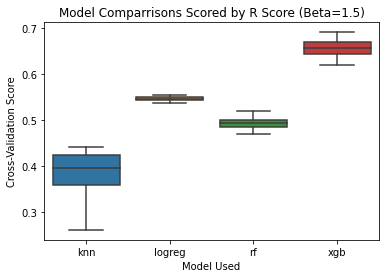

In [14]:
sns.boxplot(x='model', y='score', data=scores)
plt.xlabel('Model Used')
plt.ylabel('Cross-Validation Score')
plt.title('Model Comparrisons Scored by R Score (Beta=1.5)');

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(y_test, vote.predict(X_test))

0.6660724896019014

In [17]:
print(classification_report(y_holdout, vote.predict(X_holdout)))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       623
           1       0.54      0.55      0.54       381

    accuracy                           0.65      1004
   macro avg       0.63      0.63      0.63      1004
weighted avg       0.65      0.65      0.65      1004



Text(0.5, 1.0, 'Confusion Matrix from Predictions from Holdout Data')

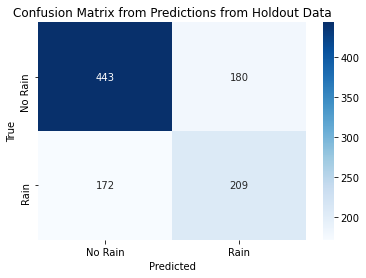

In [18]:
ticks_ = ['No Rain', 'Rain']
sns.heatmap(confusion_matrix(y_holdout, vote.predict(X_holdout)), annot=True, fmt='d', cmap='Blues', xticklabels=ticks_, yticklabels=ticks_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix from Predictions from Holdout Data')

In [19]:
perform = X_holdout.copy(deep=True)
perform['y_true'] = y_holdout
perform['vote_preds'] = vote.predict(X_holdout)

In [20]:
perform['correct_preds'] = (perform.y_true==perform.vote_preds)

Incorrect predictions are spread out through the months. No real revelation.  

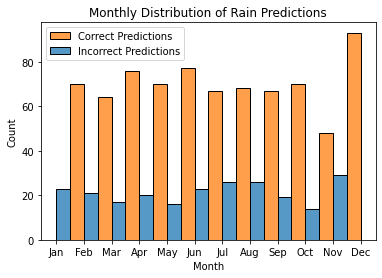

In [60]:
sns.histplot(x='month', data=perform, hue='correct_preds', multiple='dodge')
# title
plt.legend(['Correct Predictions', 'Incorrect Predictions'])
plt.title('Monthly Distribution of Rain Predictions');
plt.xlabel('Month');
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

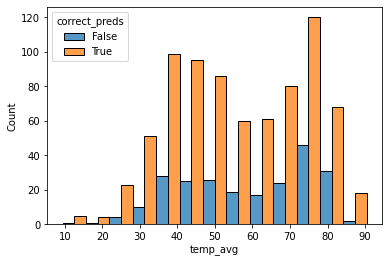

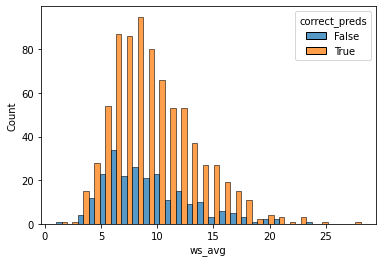

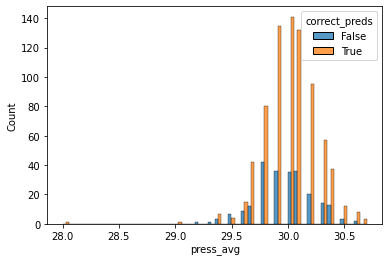

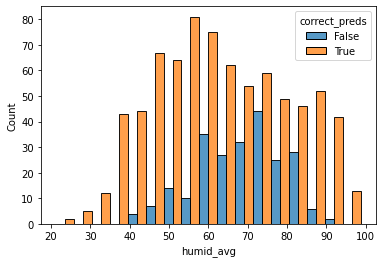

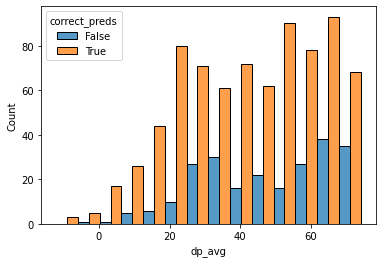

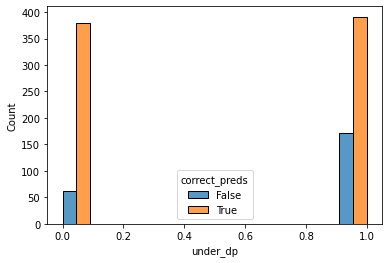

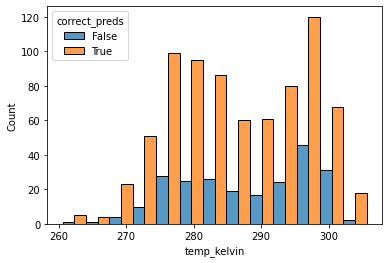

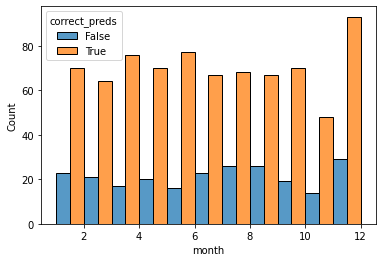

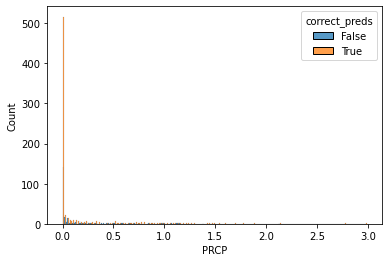

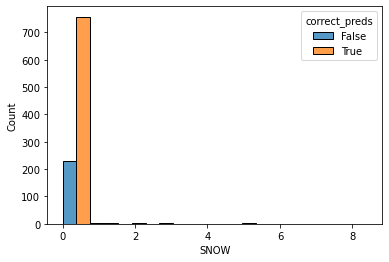

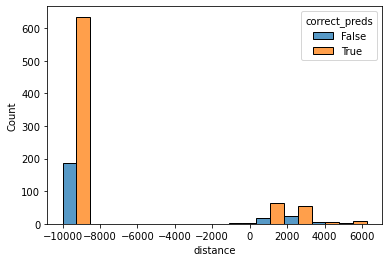

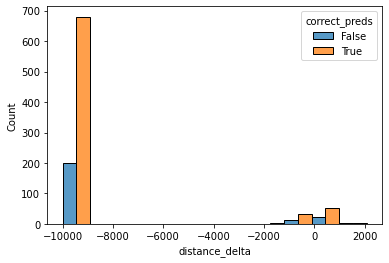

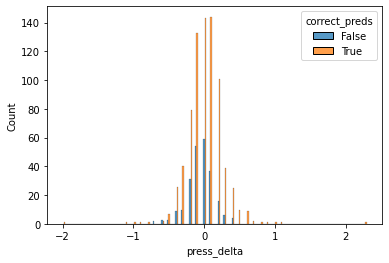

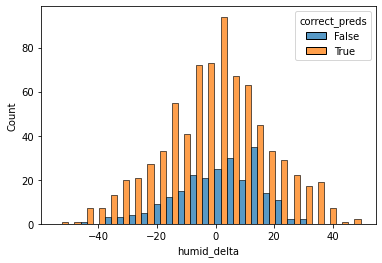

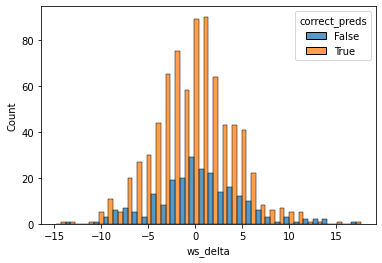

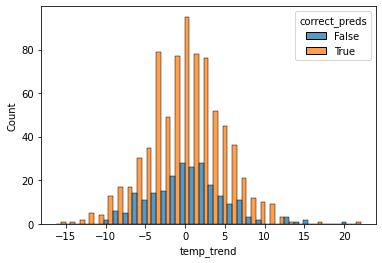

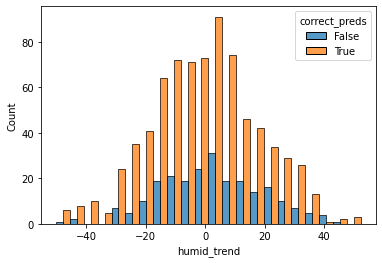

In [35]:

columns_to_check = ['temp_avg', 'ws_avg', 'press_avg', 'humid_avg', 'dp_avg', 'under_dp',
       'temp_kelvin', 'month', 'PRCP', 'SNOW', 'distance',
       'distance_delta', 'press_delta', 'humid_delta', 'ws_delta',
       'temp_trend', 'humid_trend']
    
for each in columns_to_check:
    plt.figure()
    sns.histplot(x=each, data=perform, hue='correct_preds', multiple='dodge')

Take Aways:
Most distributions are Normal with the same ratio of Correctly Predicted Values to their Incorrectly predicted counterparts.
The exceptions are for the following:
* Performs poorly on low pressure environments (<29.7)
* When the previous day is in the humidity level between 65-75%, the model predicts more incorrect values. 
* When the humidity increases by about 12% or more, there is a spike in incorrect predictions. 

Further investigations on these three points below:

In [39]:
def get_confusion_type(y_true, y_preds):
    """
    Returns result of prediction, TP/TN/FN/FP
    args:
        y_true (series): array of true values
        y_preds (series): array of predictions
    returns:
        result (list): list of confusion types
    """
    result = []
    for y, y_p in zip(y_true, y_preds):
        if y == y_p and y==1:
            result.append('TP')
        elif y == y_p and y==0:
            result.append('TN')
        elif y != y_p and y==1:
            result.append('FN')
        else:
            result.append('FP')
    return result

perform['confusion'] = get_confusion_type(perform['y_true'], perform['vote_preds'])

<AxesSubplot:xlabel='press_avg', ylabel='Count'>

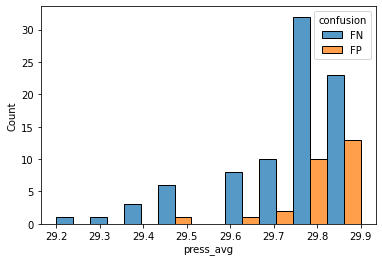

In [52]:
p_df = perform[(perform.press_avg<30) & (perform.correct_preds==0)]
sns.histplot(x='press_avg', hue='confusion', data=p_df, multiple='dodge')

My model had a higher number of False Negatives at low pressure.  In other words: False Negatives are when the day rains but I predicted no rain.  The Worst Outcome! :frowning_face:

Let's see why:

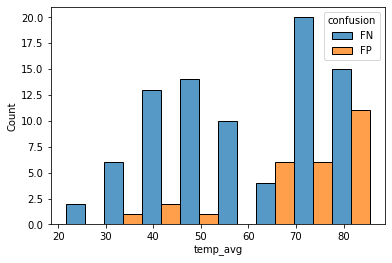

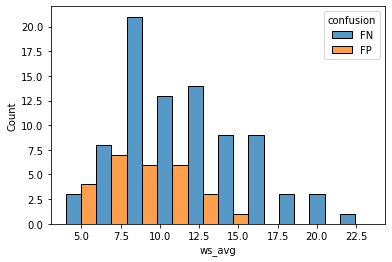

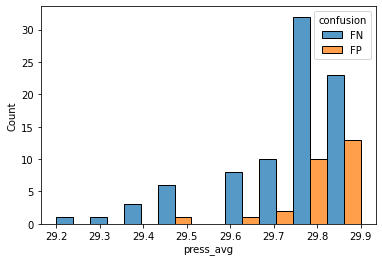

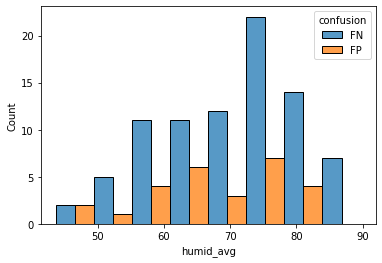

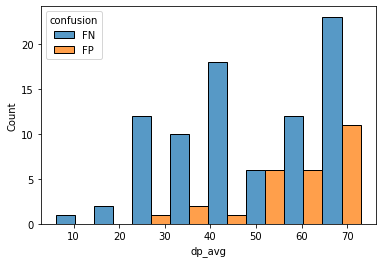

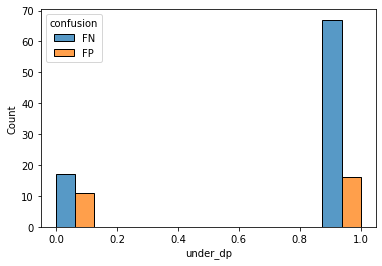

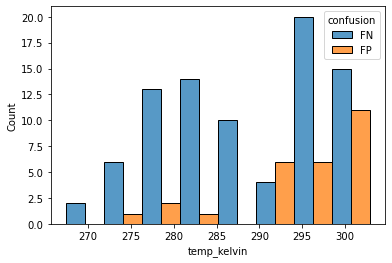

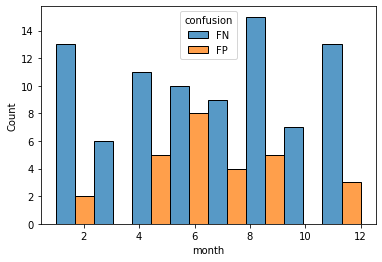

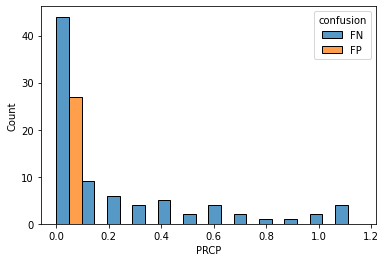

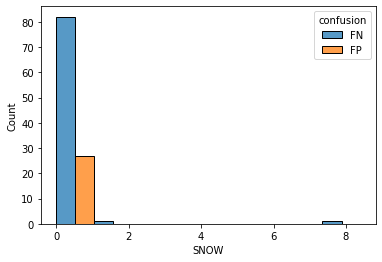

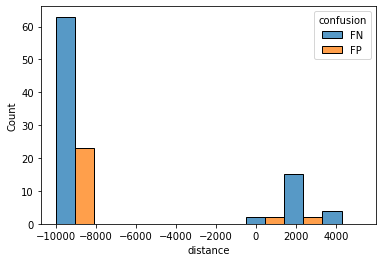

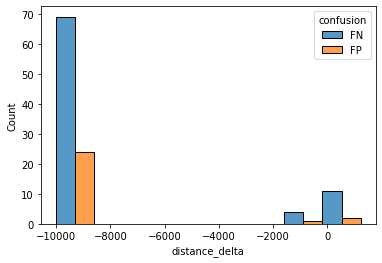

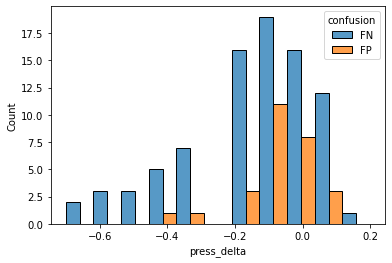

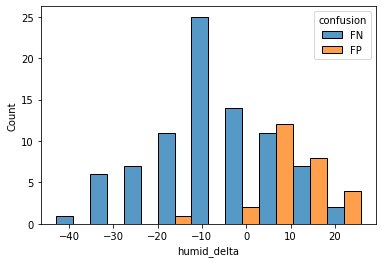

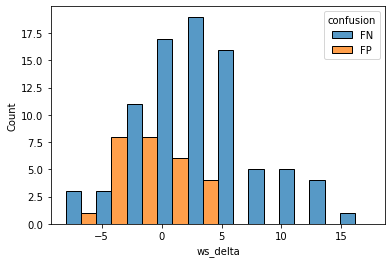

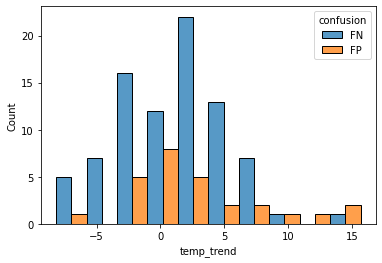

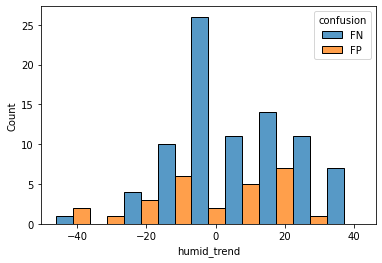

In [57]:
for each in columns_to_check:
    plt.figure()
    sns.histplot(x=each, hue='confusion', data=p_df, multiple='dodge')

In almost all the false negatives with low pressure, the previous day had rained.   
Out of the total days, the low pressure sample only represents about 10% of the days.

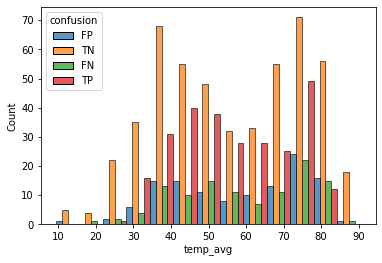

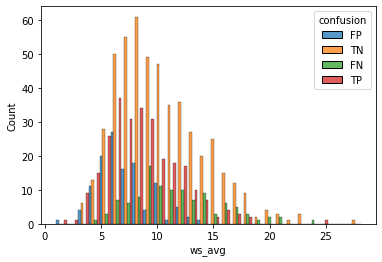

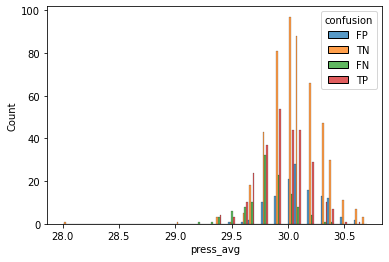

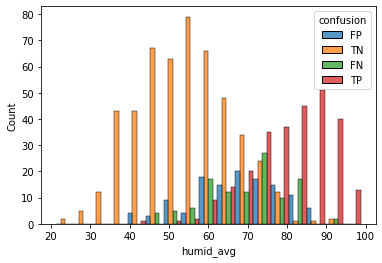

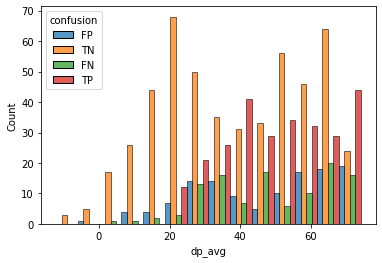

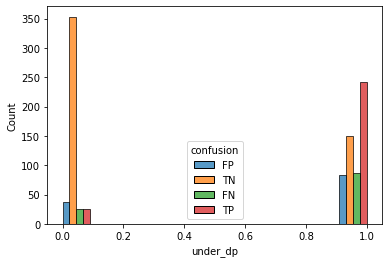

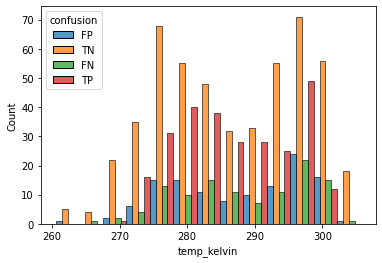

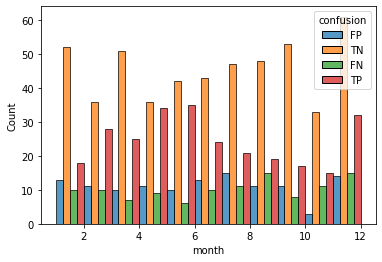

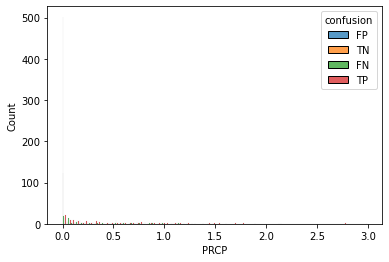

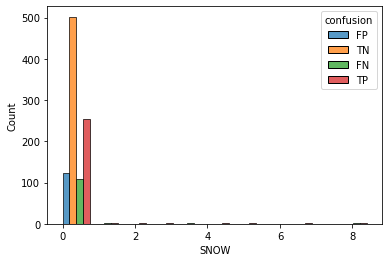

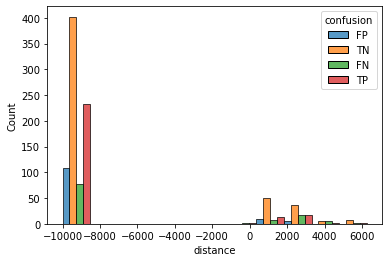

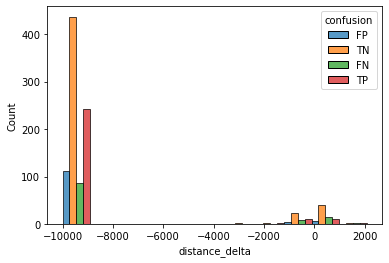

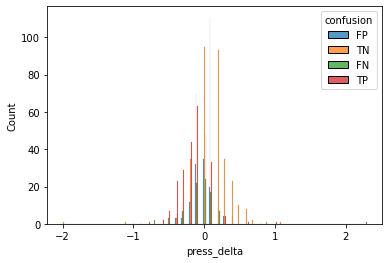

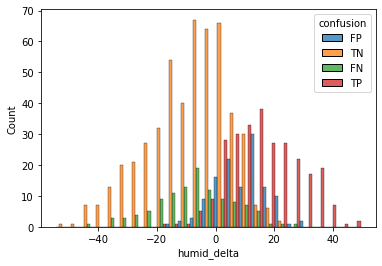

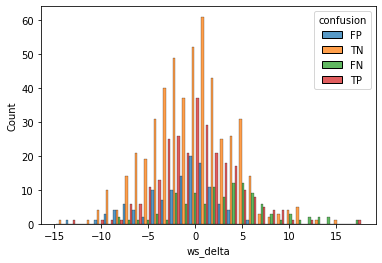

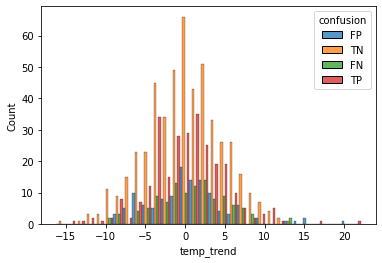

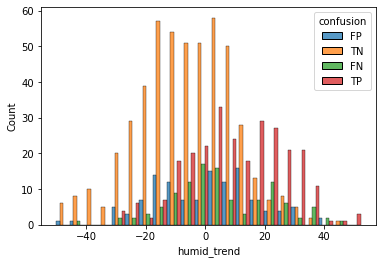

In [60]:
for each in columns_to_check:
    plt.figure()
    sns.histplot(x=each, data=perform, hue='confusion', multiple='dodge')